# Notebook to study short term persistence from multiple exposures in a single visit 


In [1]:
from astropy.io import fits
import glob, os, shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sigmaclip
from scipy.optimize import curve_fit
from scipy.special import gammaincc, gamma
from astropy.wcs import WCS
from astropy.stats import histogram

%matplotlib notebook

In [2]:
# The project dir 
pdir = '/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence/'

#The mosaic dir
mdir = pdir+'/Mosaic_hi_res_folder/'

In [ ]:
#Single and double exponential models to be fitted to the data

def decay1(t,a1,t1):
    e1 = a1*np.exp(-t/t1)
    return e1

def intdec1(t,a1,t1):
    tu = t[1:]
    td = t[:-1]
    k  = -a1*t1
    return k*(np.exp(-tu/t1)-np.exp(-td/t1))/(tu-td)
    
def decay2(t,a1,t1,a2,t2):
    e1 = a1*np.exp(-t/t1)
    e2 = a2*np.exp(-t/t2)
    return e1+e2

def intdec2(t,a1,t1,a2,t2):
    tu = t[1:]
    td = t[:-1]
    k1,k2  = -a1*t1, - a2*t2
    
    return k1*(np.exp(-tu/t1)-np.exp(-td/t1))/(tu-td) + k2*(np.exp(-tu/t2)-np.exp(-td/t2))/(tu-td)

#Single exponential models plus a constant

def intdec1_plusconst(t,a1,t1,q):
    tu = t[1:]
    td = t[:-1]
    k  = -a1*t1
    return k*(np.exp(-tu/t1)-np.exp(-td/t1))/(tu-td) +q

def dec1_plusconst(t,a1,t1,q):
    e1 = a1*np.exp(-t/t1)
    return e1+q


#Shifted power law model

def shpwl(t,t0,A,index):
    return A * ((t+t0)/1000)**index

def intshpwl(t,t0,A,index):
    tu = t[1:]
    td = t[:-1]

    if (index == -1.):
        return A*np.log( (tu+t0)/(td+t0) )
    else:
        return A/(1+index) * ( ((tu+t0)/1000)**(1+index) - ((td+t0)/1000)**(1+index) )/(tu-td)
    
    
#Schechter like model

def schechter(t,phi,alpha,tstar):
    x = t/tstar
    return phi*(x**alpha)*np.exp(-x)

def intschechter(t,phi,alpha,tstar):
    x = t/tstar

    tu = x[1:]
    td = x[:-1]

    g1 = gammaincc(alpha+1,td)
    g2 = gammaincc(alpha+1,tu)
    
    diff = gamma(alpha+1)*(g1-g2)
    
    return phi*diff

In [ ]:
#Geometric median calculation function

from scipy.spatial.distance import cdist, euclidean

def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1, D

        y = y1



In [ ]:
#Read files, make sure they are sorted by EXPSTART

sflts= []

for vis in ['1','2','3']:
    wdir = pdir+'/14016_data/Visit0'+vis+'/'
    flts = glob.glob(wdir+'*_flt.fits')
    print('***************')
    starttimes = []
    endtimes   = []
    imagetypes = []
    for flt in flts:
        starttimes.append(fits.getheader(flt,0)['EXPSTART'])
        endtimes.append(fits.getheader(flt,0)['EXPEND'])
        imagetypes.append(fits.getheader(flt,0)['IMAGETYP'])
    
    ii = np.argsort(starttimes)
    for jj in range(len(flts)):
        print(starttimes[ii[jj]],endtimes[ii[jj]],imagetypes[ii[jj]],flts[ii[jj]])


    sflts.append([flts[i] for i in ii])



In [ ]:
# Choose which visit(s) to work on

visit_indexes = [0] 
vsflts = []
for ind in visit_indexes:
    vsflts.extend(sflts[ind])
          
vsflts = vsflts[0:9]

#plot all exposures multiple times for visualization of the selected pixels

sf=1
fig = plt.figure(figsize=(sf*len(vsflts),sf*len(vsflts)))

ax = []
for i,flt in enumerate(vsflts):
    im = fits.getdata(flt)
    c, low, upp = sigmaclip(im, 2.5,3)
    mn = np.amin(c)
    print(flt,'clipped mean: ',mn)
    j = -1
    while j < i: 
        j+=1
        ax.append(plt.subplot(len(vsflts),len(vsflts),j*len(vsflts)+1+i))
        ax[-1].imshow(np.log10(im-mn),cmap='viridis', interpolation='none', origin='lower')
        ax[-1].set_title(flt[-18:-9],fontsize=6)
        ax[-1].get_xaxis().set_ticks([])
        ax[-1].get_yaxis().set_ticks([])
        
        
# Read the mosaic file and plot it

plt.tight_layout()
mosaic = fits.open(mdir+'/F140W_Mosaic_WFC3_IR_drz.fits')

ax.append(plt.subplot(len(vsflts),len(vsflts),j*len(vsflts)+1))

pos1 = ax[-1].get_position() # get the original position 
pos2 = [pos1.x0, pos1.y0,  pos1.width * len(vsflts)/2., pos1.height * len(vsflts)/2.] 
ax[-1].set_position(pos2) # set a new position
ax[-1].get_xaxis().set_ticks([])
ax[-1].get_yaxis().set_ticks([])
        
c, low, upp = sigmaclip(mosaic[1].data[np.where(np.isfinite(mosaic[1].data))], 2.5,3)
mn = np.amin(c)
im = ax[-1].imshow(np.log10(mosaic[1].data-mn),cmap='viridis', interpolation='none', origin='lower')
ax[-1].set_title('Drizzled \n mosaic',fontsize=6)



In [ ]:
#Create the wcs objects for the AD mosaic and flts 

w_mosaic = WCS(mosaic[1].header)

w_vsflts = []
for vsflt in vsflts:
    w_vsflts.append(WCS(fits.getheader(vsflt,1)))



In [ ]:
# Define a function that takes the vsflts list, the current flt that is being used as stimulus
# and looks for all the pixels with valid stimulus values AND that have valid ramps (i.e. no source, only sky)
# in the following exposures

def find_ramps(istim,flts,lev_u,lev_d):
    
    print('**********************')
    print('Doing: ',flts[istim])
    stimdata  = fits.getdata(flts[istim])
    istimgood = (stimdata > lev_d) & (stimdata < lev_u)  
    print('Pixels with potentially right stimuli:',np.sum(istimgood) )

    
    for i,pflt in enumerate(flts[0:istim]):
    
        persdata = fits.getdata(pflt)
        if (fits.getheader(pflt,0)['IMAGETYP'] == 'EXT'):  
            #msky = np.nanmean(sigmaclip(persdata,2.5,2.5)[0])
            #ssky = np.nanstd(sigmaclip(persdata,2.5,2.5)[0])
            #istimgood = istimgood & (persdata <msky+1*ssky) & (persdata >msky-1*ssky)    
            istimgood = istimgood & (persdata < 0.1*stimdata)  

            
    print('Pixels with really right stimuli:',np.sum(istimgood) )
    
    
    icount    = np.zeros_like(stimdata,dtype=np.int_)
    iprev     = istimgood
    for i,pflt in enumerate(flts[istim+1:]):
    
        persdata = fits.getdata(pflt)
        
        if (fits.getheader(pflt,0)['IMAGETYP'] == 'EXT'):  
            msky = np.nanmean(sigmaclip(persdata,2.5,2.5)[0])
            ssky = np.nanstd(sigmaclip(persdata,2.5,2.5)[0])
            iskycurr = (persdata <msky+1*ssky) & (persdata >msky-1*ssky)    
        
        elif (fits.getheader(pflt,0)['IMAGETYP'] == 'DARK'):
            iskycurr = np.ones_like(persdata,dtype=np.bool_)
        else:
            print('Wrong image type')
            assert False
        
        igood = istimgood & iskycurr & iprev
        iprev = igood
        
        icount[igood] += 1

        print('Pixels with ramps extending for at least',i+1,' exposures:', igood.sum())
        
        if (np.sum(igood) == 0):
            break
    
    
          
    return icount

In [ ]:
# Dedfine a function to get the sky value in the cureent flt pixel, but measured form the AD mosaic

def getskyfrommosaic(wcsAD, wcsFLT, x, y, dxgrid, dygrid, skyrad_o,skyrad_i,drz_fin,mask_sky_contam,mosaic):

    coords = wcsAD.all_world2pix(wcsFLT.all_pix2world(np.array([[x,y]],dtype=np.float_),0),0) 
    dx = coords[0,0]
    dy = coords[0,1]
    
    dst = np.sqrt((dxgrid-dx)**2 + (dygrid-dy)**2)
    msk = (dst<skyrad_o) & (dst > skyrad_i) & drz_fin & mask_sky_contam 
    skyarr = mosaic[1].data[msk]
    cskyarr,l,u = sigmaclip(skyarr,2.,2.)
    return np.nanmean(cskyarr)

# Similar but for darks

def getbackgroundfordarks (x, y, xgrid, ygrid, skyrad_o,skyrad_i, fltdata):

    dst = np.sqrt((xgrid-x)**2 + (ygrid-y)**2)
    msk = (dst<skyrad_o) & (dst > skyrad_i)
    skyarr = fltdata[msk]
    cskyarr,l,u = sigmaclip(skyarr,2.,2.)
    return np.nanmean(cskyarr)



In [ ]:
#Define the stimuli e-/s level to identify the ramps

lev_u = np.inf
lev_d = 3e4

# Define the pixel grid (to trasform indices in x,y positions)
xgrid,ygrid = np.meshgrid( np.arange(fits.getdata(vsflts[0],1).shape[1]) ,np.arange(fits.getdata(vsflts[0],1).shape[0]))
dxgrid,dygrid = np.meshgrid( np.arange(mosaic[1].data.shape[1]) ,np.arange(mosaic[1].data.shape[0]))

drz_fin = np.isfinite(mosaic[1].data)

msky_d = np.nanmean(sigmaclip(mosaic[1].data[drz_fin],2.5,2.5)[0])
ssky_d = np.nanstd(sigmaclip(mosaic[1].data[drz_fin],2.5,2.5)[0])
mask_sky_contam = (mosaic[1].data <msky_d+3*ssky_d) & (mosaic[1].data >msky_d-3*ssky_d)


skyrad_o = 25
skyrad_i = 15

# Open all the imas and put them in a list

imas = []
for vsflt in vsflts:
    imas.append(fits.open(vsflt.replace('_flt','_ima')))



In [ ]:
# The dataframe that will host the ramps

dfl = []

for istim,stim in enumerate(vsflts[:-1]):

    icount    = find_ramps(istim,vsflts,lev_u,lev_d)
    tendMJD   = fits.getheader(vsflts[istim])['EXPEND']
    stimdata  = fits.getdata(vsflts[istim],1)
    
    nz     = np.nonzero(icount)    
    nnexts = icount[nz]
    
    
    for nz0,nz1,nnext in zip(nz[0],nz[1],nnexts):
        for j in range(1,nnext+1,1):

            #Get the sky from the drizzled image

            if(fits.getheader(vsflts[istim+j])['IMAGETYP'] == 'EXT'):
                skyhere = getskyfrommosaic(w_mosaic, w_vsflts[istim+j], nz1, nz0, dxgrid, dygrid, skyrad_o,skyrad_i,drz_fin,mask_sky_contam,mosaic)
            elif(fits.getheader(vsflts[istim+j])['IMAGETYP'] == 'DARK'):
                skyhere = getbackgroundfordarks(nz1, nz0, xgrid, ygrid, skyrad_o,skyrad_i, fits.getdata(vsflts[istim+j],1))
            else:
                print('Wrong image type')
                assert False

            
            offset = (imas[istim+j][0].header['EXPSTART'] - tendMJD)*24.*60*60
            for k in range(imas[istim+j][0].header['NSAMP']-1):
                
                te = imas[istim+j]['TIME',k+1].header['PIXVALUE']
                ts = imas[istim+j]['TIME',k+2].header['PIXVALUE']

                tfromstim = te + offset

                tdenom = te - ts  
                meancurr  = ( ((imas[istim+j]['SCI',k+1].data[5:-5,5:-5])[nz0,nz1]*te -
                               (imas[istim+j]['SCI',k+2].data[5:-5,5:-5])[nz0,nz1]*ts)/
                               tdenom
                            )

                stdvcurr  = ( np.sqrt(np.sum(np.square([(imas[istim+j]['ERR',k+1].data[5:-5,5:-5])[nz0,nz1]*te,
                                                        (imas[istim+j]['ERR',k+2].data[5:-5,5:-5])[nz0,nz1]*ts
                                                       ]
                                                      )
                                            )
                                     ) /tdenom
                            )
                

                dfl.append([stimdata[nz0,nz1],nz1,nz0,tfromstim,meancurr,stdvcurr,skyhere,istim,istim+j])

    


In [ ]:
df=pd.DataFrame(dfl,columns=['Stim','xpix','ypix','tfromstim','meancurr','stdvcurr','ADsky','Ind_stim','Ind_pers'])
df.head()


In [ ]:

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for i in range(len(vsflts)):
    df2 = df[df['Ind_stim'] == i]
    ax1.scatter(df2.tfromstim,df2.meancurr-df2.ADsky,s=2,alpha=0.7)
    ax2.scatter(df2.tfromstim,df2.meancurr-df2.ADsky,s=2,alpha=0.7)

step = 25.
tmin = np.min(df.tfromstim.values)
tmax = np.max(df.tfromstim.values)

tmed   = []
medsig = []

while tmin <= tmax:

    BM =  (df.tfromstim.values > tmin-step/2.) & (df.tfromstim.values <= (tmin+ step/2.))
    tmin += step
    
    tmed.append(np.mean(df[BM].tfromstim))
    medsig.append(np.nanmean(sigmaclip((df[BM].meancurr.values-df[BM].ADsky.values),2.5,2.5)[0]))
    
ax1.plot(tmed,medsig)
ax2.plot(tmed,medsig)
                   
    
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(0.1,50)
ax1.set_ylim(-20,50)


In [ ]:
#NSAMP

nsamp = fits.getheader(pfltname)['NSAMP']
pimahdu = fits.open(pimaname)
pflthdu = fits.open(pfltname)
sflthdu = fits.open(sfltname)


ramps = np.zeros([np.sum(igood),nsamp-1])
eramps = np.zeros([np.sum(igood),nsamp-1])
rfits = np.zeros(np.sum(igood))
sfits = np.zeros(np.sum(igood))
mfits = np.zeros(np.sum(igood))
ffits = np.zeros(np.sum(igood))
dfits = np.zeros(np.sum(igood))
nsky  = np.zeros(np.sum(igood))
ncsky  = np.zeros(np.sum(igood))


nramps = np.sum(igood)
print('Number of ramps',np.sum(igood))

skyrad_o = 25
skyrad_i = 15

times = np.zeros(nsamp-1)
xgrid,ygrid = np.meshgrid( np.arange(pflthdu[1].data.shape[1]) ,np.arange(pflthdu[1].data.shape[0]))
dxgrid,dygrid = np.meshgrid( np.arange(mosaic[1].data.shape[1]) ,np.arange(mosaic[1].data.shape[0]))

drz_fin = np.isfinite(mosaic[1].data)

msky_d = np.nanmean(sigmaclip(mosaic[1].data[drz_fin],2.5,2.5)[0])
ssky_d = np.nanstd(sigmaclip(mosaic[1].data[drz_fin],2.5,2.5)[0])
mask_sky_contam = (mosaic[1].data <msky_d+3*ssky_d) & (mosaic[1].data >msky_d-3*ssky_d)



for i in range(nsamp-1):
    edt = pimahdu['ERR',i+1].data[5:-5,5:-5]
    eramps[:,i] = edt[igood]
    times[i] = pimahdu['TIME',i+1].header['PIXVALUE']
    dt = (pimahdu['SCI',i+1].data[5:-5,5:-5]*times[i] -  pimahdu['SCI',i+2].data[5:-5,5:-5]*pimahdu['TIME',i+2].header['PIXVALUE'])/(times[i]-pimahdu['TIME',i+2].header['PIXVALUE'])
    ramps[:,i] = dt[igood]

toff = pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND']
    
goodx = xgrid[igood]
goody = ygrid[igood]
    
for j in range(nramps):
    rfits[j] = pflthdu[1].data[igood][j]
    sfits[j] = sflthdu[1].data[igood][j]
    ix = goodx[j]
    iy = goody[j]

    #Fit the sky using neighboring pixels
    dst = np.sqrt((xgrid-ix)**2 + (ygrid-iy)**2)
    msk = (dst<skyrad_o) & (dst > skyrad_i)
    skyarr = pflthdu[1].data[msk]
    cskyarr,l,u = sigmaclip(skyarr,2.,2.)
    mfits[j] = np.nanmean(cskyarr)
    nsky[j] = skyarr.size
    ncsky[j] = cskyarr.size
    
    #Fit the sky using an exponential + costant model
#   pars, cov = curve_fit(dec1_plusconst, times[::-1]+toff,ramps[j,::-1],p0=[4,100,30])
#   ffits[j] = pars[-1]
    
    #Get the sky from the drizzled image

    coords = w_mosaic.all_world2pix(w_pers.all_pix2world(np.array([[ix,iy]],dtype=np.float_),0),0) 
    dx = coords[0,0]
    dy = coords[0,1]
    
    
    dst2 = np.sqrt((dxgrid-dx)**2 + (dygrid-dy)**2)
    msk2 = (dst2<skyrad_o) & (dst2 > skyrad_i) & drz_fin & mask_sky_contam 
    skyarr = mosaic[1].data[msk2]
    cskyarr,l,u = sigmaclip(skyarr,2.,2.)
    dfits[j] = np.nanmean(cskyarr)
    
    
    
isort = np.argsort(sfits)[::-1]

sfits = sfits[isort]
rfits = rfits[isort]
mfits = mfits[isort]
ffits = ffits[isort]
dfits = dfits[isort]

nsky  = nsky[isort]
ncsky  = ncsky[isort]




In [ ]:
# Find out how much persistence knox's model would have predicted

import knox_stuff as kls

tima = (np.append(times,0)+toff)[::-1]

klp = np.zeros_like(ramps)
agmodel = kls.read_models_spv()

subint = 100

for j in range(len(tima)-1):
    ts = tima[j]
    te = tima[j+1]
    ti = np.linspace(ts, te, num=subint)  
    part_klp = np.zeros([nramps,subint])
    
    for i in range(subint):
        part_klp[:,i] = kls.make_persistence_image_spv(sfits,agmodel,exptime=sfhdr0['EXPTIME'],dt=ti[i])

    for k in range(nramps):
        klp[k,j] = np.trapz(part_klp[k,:],x=ti)

    klp[:,j] /= (te-ts)
    print(te-ts,j)
        
klp = klp[:,::-1] 


In [ ]:
plot_every = 70
ppr = 3

nplots = (nramps+plot_every-1)//plot_every 
nrows = (nplots+ppr-1)//ppr

fig = plt.figure(figsize=(3.75*ppr,6*nrows))
deltat   = np.logspace(np.log10(times[0]+pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND']),
                       np.log10(times[-1]+pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND']),100)

ax = []
for j,aa in enumerate(range(0,nramps,plot_every)):

    ax.append(fig.add_subplot(nrows,ppr,j+1))
#    ax[-1].errorbar(times[:-1],ramps[aa,:-1],yerr=eramps[aa,:-1],c='r')
    ax[-1].errorbar(times,ramps[aa,:],yerr=eramps[aa,:])
#    ax[-1].plot(deltat,6.5*np.exp(-deltat/135)+rfits[aa])    
    ax[-1].axhline(dfits[aa],color='g',label='Median Sky (from AD)'+'% .2f' %dfits[aa])
    ax[-1].axhline(mfits[aa],color='r',label='Median Sky (from flt)'+'% .2f' %mfits[aa])
    ax[-1].axhline(rfits[aa],color='magenta',label='Flt estimate'+'% .2f' %rfits[aa])#
#    ax[-1].axhline(ffits[aa],color='orange',label='Fitted sky'+'% .2f' %ffits[aa])
    ylim = ax[-1].get_ylim()
    ylim = list(ylim)
    ylim[1]+=10
    ylim=tuple(ylim)
    ax[-1].plot(times,klp[aa,:]+mfits[aa],label='A-$\gamma$ pers')    

    ax[-1].legend()
    ax[-1].set_title('Pixel:('+str(goodx[aa])+','+str(goody[aa])+')'+'\n Stimulus =  '+'% .1f' % sfits[aa] +' $ e^- s^{-1}$')
    ax[-1].set_ylim(ylim)

    ax[-1].set_xlabel('Time [s]')
    ax[-1].set_ylabel('Mean current [$ e^- s^{-1}$]')
    
    #    ax[-1].set_yscale('log')
#    ax[-1].set_xscale('log')
    
    
plt.tight_layout()

In [ ]:
toff = pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND']
#tmod   = np.linspace(times[0],times[-1],100)
#deltat = pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND'] + tmod

ufits = dfits

mnp = np.zeros(nsamp-1)
mdp = np.zeros(nsamp-1)
sdp = np.zeros(nsamp-1)

mnp_klp = np.zeros(nsamp-1)
mdp_klp = np.zeros(nsamp-1)
sdp_klp = np.zeros(nsamp-1)


for nn in range(nsamp-1):
    mnp[nn] = np.mean(ramps[:,nn]-ufits)
    mdp[nn] = np.median(ramps[:,nn]-ufits)    
    c,l,u = sigmaclip(ramps[:,nn]-ufits,2.,2.)
    sdp[nn] = np.nanstd(c)

    mnp_klp[nn] = np.mean(klp[:,nn])
    mdp_klp[nn] = np.median(klp[:,nn])    
    c,l,u = sigmaclip(klp[:,nn],2.,2.)
    sdp_klp[nn] = np.nanstd(c)


gmp, Dgm = geometric_median(ramps-ufits[:,None], eps=1e-5)  

#Get the 68% closest curvees
idsort = np.argsort(Dgm[:,0])[0:nramps*0.68]

for nn in range(nsamp-1):
    sdp[nn] = np.nanstd(ramps[idsort,nn]-ufits[idsort])
  

#gmp_klp = geometric_median(klp, eps=1e-5)    
    

#popt1_md, pcov1_md = curve_fit(decay1, times+toff,mdp,sigma=sdp,p0=[4,100])
#popt1_mn, pcov1_mn = curve_fit(decay1, times+toff,mnp,sigma=sdp,p0=[4,100])
#popt1_gm, pcov1_gm = curve_fit(decay1, times+toff,gmp,sigma=sdp,p0=[4,100])

popt1_md_i, pcov1_md_i = curve_fit(intdec1, np.append(times,0)+toff,mdp,sigma=sdp,p0=[4,100])
popt1_mn_i, pcov1_mn_i = curve_fit(intdec1, np.append(times,0)+toff,mnp,sigma=sdp,p0=[4,100])
popt1_gm_i, pcov1_gm_i = curve_fit(intdec1, np.append(times,0)+toff,gmp,sigma=sdp,p0=[4,100])

#popt2_md, pcov2_md = curve_fit(decay2, times+toff,mdp,sigma=sdp,p0=[4,100,2,10])
#popt2_mn, pcov2_mn = curve_fit(decay2, times+toff,mnp,sigma=sdp,p0=[4,100,2,10])
#popt2_gm, pcov2_gm = curve_fit(decay2, times+toff,gmp,sigma=sdp,p0=[4,100,2,10])

popt2_md_i, pcov2_md_i = curve_fit(intdec2, np.append(times,0)+toff,mdp,sigma=sdp,p0=[4,100,2,10])
popt2_mn_i, pcov2_mn_i = curve_fit(intdec2, np.append(times,0)+toff,mnp,sigma=sdp,p0=[4,100,2,10])
popt2_gm_i, pcov2_gm_i = curve_fit(intdec2, np.append(times,0)+toff,gmp,sigma=sdp,p0=[4,100,2,10])

poptSG_md_i, pcovSG_md_i = curve_fit(intshpwl, np.append(times,0)+toff,mdp,sigma=sdp,p0=[-1,100,-1.05])
poptSG_mn_i, pcovSG_mn_i = curve_fit(intshpwl, np.append(times,0)+toff,mnp,sigma=sdp,p0=[-1,100,-1.05])
poptSG_gm_i, pcovSG_gm_i = curve_fit(intshpwl, np.append(times,0)+toff,gmp,sigma=sdp,p0=[-1,100,-1.05])

poptSC_md_i, pcovSC_md_i = curve_fit(intschechter, np.append(times,0)+toff,mdp,sigma=sdp,p0=[10,2,100])
poptSC_mn_i, pcovSC_mn_i = curve_fit(intschechter, np.append(times,0)+toff,mnp,sigma=sdp,p0=[10,2,100])
poptSC_gm_i, pcovSC_gm_i = curve_fit(intschechter, np.append(times,0)+toff,gmp,sigma=sdp,p0=[10,2,100])




#print('*********')
#print('1 Exp decay')
#print(popt1_mn)
#print(popt1_md)
#print(popt1_gm)
print('*********')
print('1 Exp decay, integrated')
print(popt1_mn_i)
print(popt1_md_i)
print(popt1_gm_i)
#print('*********')
#print('2 Exp decay')
#print(popt2_mn)
#print(popt2_md)
#print(popt2_gm)
print('*********')
print('2 Exp decay integrated')
print(popt2_mn_i)
print(popt2_md_i)
print(popt2_gm_i)
print('*********')
print('Shifted power law decay integrated')
print(poptSG_mn_i)
print(poptSG_md_i)
print(poptSG_gm_i)
print('*********')
print('Schechter decay integrated')
print(poptSC_mn_i)
print(poptSC_md_i)
print(poptSC_gm_i)


In [ ]:
fig = plt.figure(figsize=(14,15))
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)
ax6 = fig.add_subplot(3,2,6)


deltat   = np.logspace(np.log10(times[0]+toff),np.log10(times[-1]+toff),100)

for aa in range(nramps):

    ax1.plot(times,ramps[aa,:]-ufits[aa],c='gray',alpha=.1)
    ax2.plot(times,ramps[aa,:]-ufits[aa],c='gray',alpha=.1)
    ax3.plot(times,ramps[aa,:]-ufits[aa],c='gray',alpha=.1)
    ax4.plot(times,ramps[aa,:]-ufits[aa],c='gray',alpha=.1)
    ax5.plot(times,ramps[aa,:]-ufits[aa],c='gray',alpha=.1)
    ax6.plot(times,ramps[aa,:]-ufits[aa],c='gray',alpha=.1)

    

#ax1.plot(deltat,decay1(deltat,*popt1_mn),c='r',linewidth=2)
#ax2.plot(deltat,decay1(deltat,*popt1_mn),c='r',linewidth=2)
#ax3.plot(deltat,decay1(deltat,*popt1_md),c='r',linewidth=2)
#ax4.plot(deltat,decay1(deltat,*popt1_md),c='r',linewidth=2)

ax1.plot(deltat,intdec1(np.append(deltat,0),*popt1_mn_i),linewidth=2,label='Single exp')
ax2.plot(deltat,intdec1(np.append(deltat,0),*popt1_mn_i),linewidth=2,label='Single exp')
ax3.plot(deltat,intdec1(np.append(deltat,0),*popt1_md_i),linewidth=2,label='Single exp')
ax4.plot(deltat,intdec1(np.append(deltat,0),*popt1_md_i),linewidth=2,label='Single exp')
ax5.plot(deltat,intdec1(np.append(deltat,0),*popt1_gm_i),linewidth=2,label='Single exp')
ax6.plot(deltat,intdec1(np.append(deltat,0),*popt1_gm_i),linewidth=2,label='Single exp')

#ax1.plot(deltat,decay2(deltat,*popt2_mn),c='g',linewidth=2)
#ax2.plot(deltat,decay2(deltat,*popt2_mn),c='g',linewidth=2)
#ax3.plot(deltat,decay2(deltat,*popt2_md),c='g',linewidth=2)
#ax4.plot(deltat,decay2(deltat,*popt2_md),c='g',linewidth=2)

ax1.plot(deltat,intdec2(np.append(deltat,0),*popt2_mn_i),linewidth=2,label='Double exp')
ax2.plot(deltat,intdec2(np.append(deltat,0),*popt2_mn_i),linewidth=2,label='Double exp')
ax3.plot(deltat,intdec2(np.append(deltat,0),*popt2_md_i),linewidth=2,label='Double exp')
ax4.plot(deltat,intdec2(np.append(deltat,0),*popt2_md_i),linewidth=2,label='Double exp')
ax5.plot(deltat,intdec2(np.append(deltat,0),*popt2_gm_i),linewidth=2,label='Double exp')
ax6.plot(deltat,intdec2(np.append(deltat,0),*popt2_gm_i),linewidth=2,label='Double exp')

ax1.plot(deltat,intshpwl(np.append(deltat,0),*poptSG_mn_i),linewidth=2,label='Shifted PL')
ax2.plot(deltat,intshpwl(np.append(deltat,0),*poptSG_mn_i),linewidth=2,label='Shifted PL')
ax3.plot(deltat,intshpwl(np.append(deltat,0),*poptSG_md_i),linewidth=2,label='Shifted PL')
ax4.plot(deltat,intshpwl(np.append(deltat,0),*poptSG_md_i),linewidth=2,label='Shifted PL')
ax5.plot(deltat,intshpwl(np.append(deltat,0),*poptSG_gm_i),linewidth=2,label='Shifted PL')
ax6.plot(deltat,intshpwl(np.append(deltat,0),*poptSG_gm_i),linewidth=2,label='Shifted PL')

ax1.plot(deltat,intschechter(np.append(deltat,0),*poptSC_mn_i),linewidth=2,label='Schechter')
ax2.plot(deltat,intschechter(np.append(deltat,0),*poptSC_mn_i),linewidth=2,label='Schechter')
ax3.plot(deltat,intschechter(np.append(deltat,0),*poptSC_md_i),linewidth=2,label='Schechter')
ax4.plot(deltat,intschechter(np.append(deltat,0),*poptSC_md_i),linewidth=2,label='Schechter')
ax5.plot(deltat,intschechter(np.append(deltat,0),*poptSC_gm_i),linewidth=2,label='Schechter')
ax6.plot(deltat,intschechter(np.append(deltat,0),*poptSC_gm_i),linewidth=2,label='Schechter')


ax1.errorbar(times+toff,mnp,yerr=sdp,linewidth=2,label='Mean measured persistence')
ax2.errorbar(times+toff,mnp,yerr=sdp,linewidth=2,label='Mean measured persistence')
ax3.errorbar(times+toff,mdp,yerr=sdp,linewidth=2,label='Median measured persistence')
ax4.errorbar(times+toff,mdp,yerr=sdp,linewidth=2,label='Median measured persistence')
ax5.errorbar(times+toff,gmp,yerr=sdp,linewidth=2,label='GMED measured persistence')
ax6.errorbar(times+toff,gmp,yerr=sdp,linewidth=2,label='GMED measured persistence')

ax1.errorbar(times+toff,mnp_klp,yerr=sdp_klp,linewidth=2,label='Mean A-$\gamma$ persistence')
ax2.errorbar(times+toff,mnp_klp,yerr=sdp_klp,linewidth=2,label='Mean A-$\gamma$ persistence')
ax3.errorbar(times+toff,mdp_klp,yerr=sdp_klp,linewidth=2,label='Median A-$\gamma$ persistence')
ax4.errorbar(times+toff,mdp_klp,yerr=sdp_klp,linewidth=2,label='Median A-$\gamma$ persistence')
ax5.errorbar(times+toff,mdp_klp,yerr=sdp_klp,linewidth=2,label='Median A-$\gamma$ persistence')
ax6.errorbar(times+toff,mdp_klp,yerr=sdp_klp,linewidth=2,label='Median A-$\gamma$ persistence')

    
ax2.set_yscale('log')
ax2.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xscale('log')
ax6.set_yscale('log')
ax6.set_xscale('log')

ax1.set_ylim(-20,30)
ax2.set_ylim(-20,30)
ax3.set_ylim(-20,30)
ax4.set_ylim(-20,30)
ax5.set_ylim(-20,30)
ax6.set_ylim(-20,30)
    
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
    
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(20,15))
ax = []

def gaussian(x, mu, sig):
    return 1/(sig*np.sqrt(2*np.pi)) *np.exp(-0.5 * np.square( (x - mu)/sig))


from astropy.visualization import hist as aphist

import matplotlib.patches as patches

for j,tt in enumerate(times):
    
    ax.append(fig.add_subplot(3,5,len(times)-j))

    nn, bins, patches = aphist(ramps[:,j]-ufits,ax=ax[-1],normed=True,bins='knuth')
    
    bins = np.linspace(-40,40,11)
    x = np.linspace(bins[0],bins[-1],100)
    g = gaussian(x,mnp[j],sdp[j])

    ax[-1].plot(x,g)    
    ax[-1].axvline(mnp[j],c='r')
    ax[-1].set_title(tt)


In [ ]:
fig = plt.figure(figsize=(10,6))
ax3 = fig.add_subplot(1,1,1)

deltat   = np.logspace(np.log10(times[0]+toff),np.log10(times[-1]+toff),100)

for aa in range(nramps):

    ii = ramps[aa,:]-ufits[aa] > 0
    
    ax3.plot(times,ramps[aa,:]-ufits[aa],c='gray',alpha=.1)


ax3.errorbar(times+toff,mdp,yerr=sdp,linewidth=2,label='Median measured persistence')


ax3.errorbar(times+toff,mdp_klp,yerr=sdp_klp,linewidth=2,label='Median A-$\gamma$ persistence')

ax3.plot(deltat,intdec1(np.append(deltat,0),*popt1_md_i),linewidth=2,label='Single exp')

ax3.plot(deltat,intdec2(np.append(deltat,0),*popt2_md_i),linewidth=2,label='Double exp')

    
ax3.set_ylim(-20,30)
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Mean current [$ e^- s^{-1}$]')

    
ax3.legend()
    
plt.tight_layout()


In [ ]:
hd = fits.getheader(vsflts[0],0)

print((hd['EXPEND']-hd['EXPSTART'])*24*60*60)

In [ ]:
# Print the exposure information for the stimulus image

sfltname = 'icrr01y7q_flt.fits'
pimaname = 'icrr01y8q_ima.fits'
pfltname = 'icrr01y8q_flt.fits'

sflt = fits.getdata(sfltname)
pflt = fits.getdata(pfltname)

fig = plt.figure(figsize=(15,8))

sfhdr0 = fits.getheader(sfltname,0)
sfhdr1 = fits.getheader(sfltname,1)

print(sfltname, sfhdr0['FILTER'], sfhdr0['TIME-OBS'], sfhdr0['POSTARG1'], sfhdr0['POSTARG2'], sfhdr0['EXPTIME'], sfhdr0['FILTER'])
    
ax1 = fig.add_subplot(1,2,1)
c, low, upp = sigmaclip(sflt, 2.5,3)
mn = np.amin(c)
print(mn)
im = ax1.imshow(np.log10(sflt-mn),cmap='viridis', interpolation='none', origin='lower')
ax1.set_title(sfltname)
fig.colorbar(im, ax=ax1)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(np.log10(sflt-mn),cmap='viridis', interpolation='none', origin='lower')
ax2.set_title(sfltname+' + mask')




[895, 489]
[896, 489]
[895, 490]


<IPython.core.display.Javascript object>


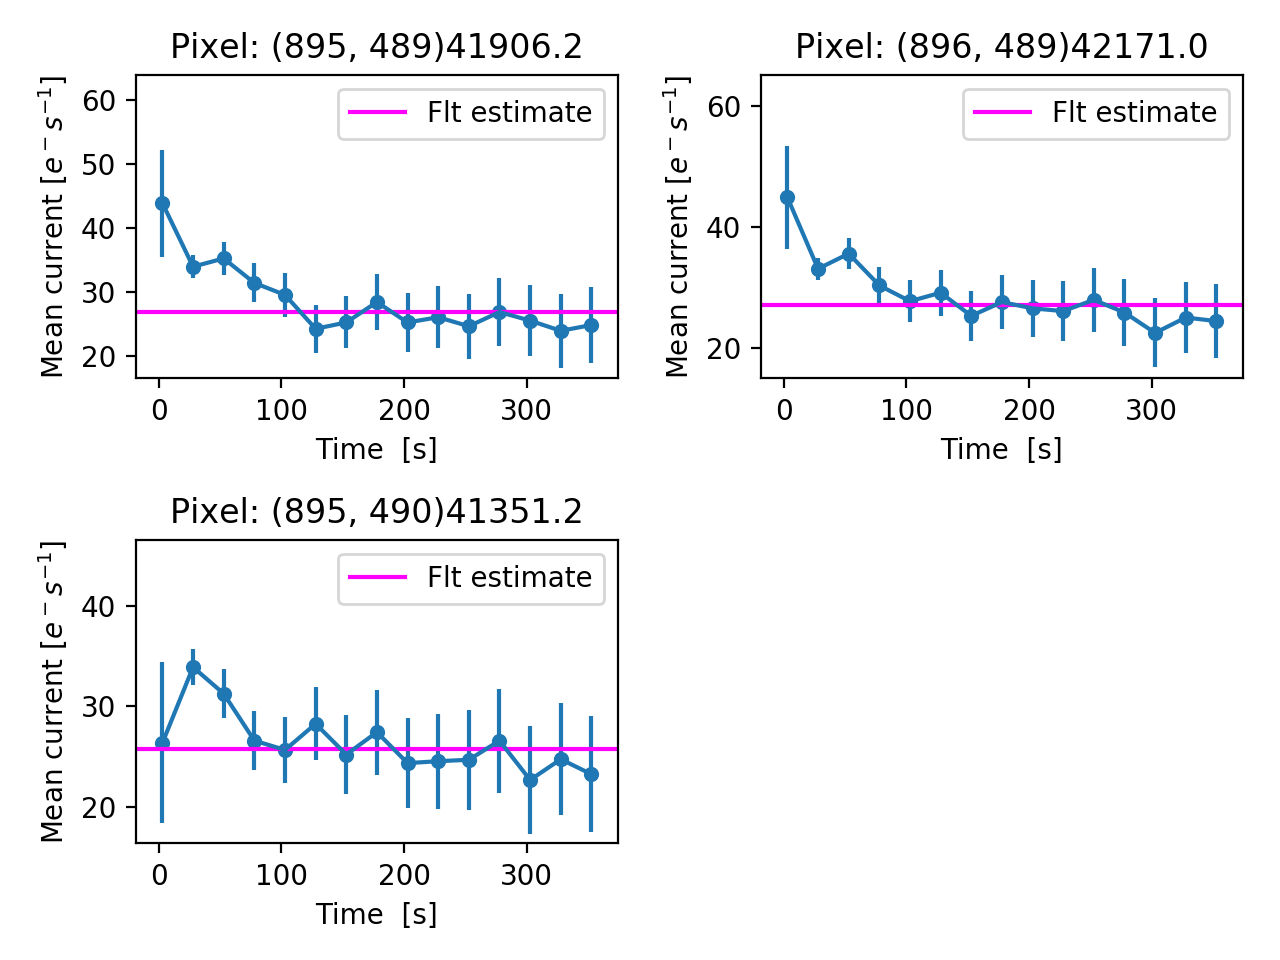

[895, 489]
[896, 489]
[895, 490]


In [41]:
wdir = pdir+'/14016_data/Visit01/'

fflt = wdir+'icrr01y8q_flt.fits'
fima = wdir+'icrr01y8q_ima.fits'
sflt = wdir+'icrr01y7q_flt.fits'


pimahdu = fits.open(fima)
pflthdu = fits.open(fflt)
sflthdu = fits.open(sflt)

#pixels_list = [[896,489],[895,489],[895,490]]

pixels_list = [[895,489],[896,489],[895,490]]

pixels = np.zeros_like(pflthdu[1].data,dtype=np.bool_)

for pix in pixels_list:
    print(pix)
    pixels[pix[1],pix[0]] = True

nsamp = 16

times  = np.zeros(nsamp-1)
ramps  = np.zeros([np.sum(pixels),nsamp-1])
eramps = np.zeros([np.sum(pixels),nsamp-1])

for i in range(nsamp-1):
    edt1 = pimahdu['ERR',i+1].data[5:-5,5:-5]
    edt2 = pimahdu['ERR',i+2].data[5:-5,5:-5]

    sdt1 = pimahdu['SCI',i+1].data[5:-5,5:-5]
    sdt2 = pimahdu['SCI',i+2].data[5:-5,5:-5]
    
    times[i] = pimahdu['TIME',i+1].header['PIXVALUE']
    t1 = times[i]
    t2 = pimahdu['TIME',i+2].header['PIXVALUE']
    tdenom = (t1-t2)
     
    for j,pix in enumerate(pixels_list):
        eramps[j,i] = (1./tdenom)*np.sqrt(np.sum(np.square([t1*edt1[pix[1],pix[0]],t2*edt2[pix[1],pix[0]]]),axis=0)) 
        ramps[j,i] = (sdt1[pix[1],pix[0]]*t1 -  sdt2[pix[1],pix[0]]*t2)/tdenom


fig = plt.figure()
ax=[]
for j,aa in enumerate(pixels_list):
    print(aa)
    ax.append(fig.add_subplot(2,2,j+1))
    
    ax[-1].errorbar(times,ramps[j,:],yerr=eramps[j,:])
    ax[-1].scatter(times,ramps[j,:],s=20)
    ax[-1].axhline(pflthdu[1].data[pixels][j],color='magenta',label='Flt estimate')
 
    ylim = ax[-1].get_ylim()
    ylim = list(ylim)
    ylim[1]+=10
    ylim=tuple(ylim)

    ax[-1].legend()
    ax[-1].set_title('Pixel: ('+str(aa[0])+', '+str(aa[1])+')'+str(sflthdu[1].data[aa[1],aa[0]]))
    ax[-1].set_ylim(ylim)

    ax[-1].set_xlabel('Time  [s]')
    ax[-1].set_ylabel('Mean current [$ e^- s^{-1}$]')

plt.tight_layout()


In [42]:
eramps

array([[ 5.92362809,  5.73145438,  5.53030167,  5.31034539,  5.08559272,
         4.85578423,  4.6126958 ,  4.34385687,  4.05991662,  3.78116797,
         3.45318779,  3.04105779,  2.51961968,  1.83529721,  8.33695698],
       [ 6.11982067,  5.91199078,  5.70717216,  5.49390938,  5.24783209,
         4.99096723,  4.73041506,  4.44860883,  4.15767772,  3.83941835,
         3.48112785,  3.07714425,  2.54875773,  1.85610664,  8.49810791],
       [ 5.79898361,  5.60805612,  5.4125515 ,  5.2026895 ,  4.97604657,
         4.74896586,  4.51276426,  4.24896693,  3.9635297 ,  3.65146435,
         3.30912656,  2.94066357,  2.47043635,  1.80422356,  8.04304218]])